In [1]:
import sys
sys.path.insert(0, "..")

In [2]:
import relabel

In [3]:
import numpy as np
import zarr
import dask.array as da
import matplotlib.pyplot as plt

In [4]:
from dask.diagnostics import ProgressBar

In [5]:
from skimage.data import cells3d
from skimage import color

In [6]:
import torch

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from cellpose import models

# Use the 3D Cells example from scikit-image

In [8]:
img = cells3d()[:, 1, :, :]

In [9]:
img.shape

(60, 256, 256)

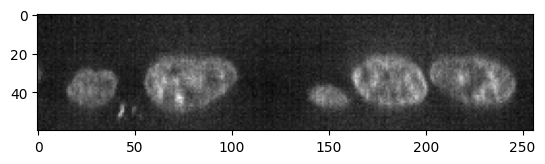

In [10]:
plt.imshow(img[:, 40, :], cmap="gray")

## Load the 3D Cellpose model

In [11]:
model = models.Cellpose(gpu=False, model_type='nuclei')

In [12]:
def cellposeLabel(im_chunk, model=None):
    masks, _, _, _ = model.eval(im_chunk, diameter=64, channels=[0, 0], flow_threshold=0.4, do_3D=True)
    masks = masks.astype(np.int32)
    return masks

In [13]:
%%time
labels_ref = cellposeLabel(img, model=model)

CPU times: user 48.7 s, sys: 4.61 s, total: 53.3 s
Wall time: 13.3 s


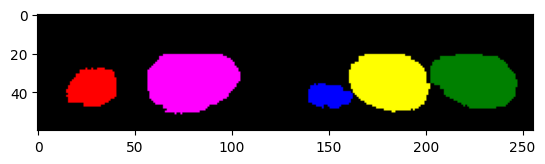

In [14]:
plt.imshow(color.label2rgb(labels_ref[:, 40, :]))

## Execute the segmentation and relabeling process

In [15]:
img_da = da.from_array(img, chunks=(60, 128, 128))
img_da

dask.array<array, shape=(60, 256, 256), dtype=uint16, chunksize=(60, 128, 128), chunktype=numpy.ndarray>

In [16]:
%%time
labels = relabel.image2labels(
    img_da,
    seg_fn=cellposeLabel,
    overlaps=[0, 64, 64],
    ndim=3,
    segmentation_fn_kwargs={"model": model}
)

CPU times: user 3.3 ms, sys: 9.21 ms, total: 12.5 ms
Wall time: 4.18 ms


In [17]:
labels

dask.array<_trim, shape=(60, 256, 256), dtype=int64, chunksize=(60, 128, 128), chunktype=numpy.ndarray>

In [18]:
%%time
with ProgressBar():
    labels = labels.compute()

[########################################] | 100% Completed | 16.83 ss
CPU times: user 1min 29s, sys: 7.16 s, total: 1min 36s
Wall time: 17.1 s


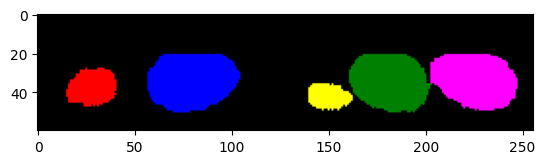

In [19]:
plt.imshow(color.label2rgb(labels[:, 40, :]))

### Compare the number of objects labeled by each method

Number of objects labeled by chunks

In [20]:
np.unique(labels).size

61

Number of objects labeled on the whole image

In [21]:
np.unique(labels_ref).size

62